In [14]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('../data/model_input_with_interactions.csv')

In [15]:
# Define full feature columns with interactions
feature_cols = [
    'gender_encoded',
    'age_group_encoded',
    'severity_encoded',
    'admission_encoded',
    'payment_type_encoded',
    'diagnosis_encoded',
    'procedure_encoded',
    'county_encoded',
    'los',
    'los_x_severity',
    'los_x_procedure',
    'severity_x_procedure',
    'los_x_county'
]

In [16]:
# Load saved models for each LOS group
model_short = joblib.load('../models/model_short.pkl')
model_moderate = joblib.load('../models/model_moderate.pkl')
model_long = joblib.load('../models/model_long.pkl')
model_extended = joblib.load('../models/model_extended.pkl')

## Define LOS Grouping Function

This function assigns each patient to a LOS category to route them to the correct model.

In [18]:
def get_los_group(los):
    if los <= 3:
        return 'short'
    elif los <= 14:
        return 'moderate'
    elif los <= 30:
        return 'long'
    else:
        return 'extended'

## Ensemble Prediction Function

This function uses the predicted LOS group to select the appropriate model and generate a charge prediction.

In [19]:
def ensemble_predict(df, feature_cols):
    df = df.copy()

    # Add LOS group label
    df['los_group'] = df['los'].apply(get_los_group)

    # Prepare output container
    preds = []

    # Loop through LOS groups and apply corresponding model
    for group, model in {
        'short': model_short,
        'moderate': model_moderate,
        'long': model_long,
        'extended': model_extended
    }.items():
        group_df = df[df['los_group'] == group]
        if not group_df.empty:
            X = group_df[feature_cols]
            y_pred_log = model.predict(X)
            y_pred = np.expm1(y_pred_log)  # Inverse log-transform
            preds.append(pd.Series(y_pred, index=group_df.index))

    # Combine all predictions
    df['ensemble_prediction'] = pd.concat(preds).sort_index()
    return df

## Evaluate Ensemble Model Performance

We apply the ensemble prediction to the full dataset and compare predicted vs. actual total charges.

In [20]:
# Apply the ensemble model
df_with_preds = ensemble_predict(df, feature_cols)

# Evaluate performance
y_true = df_with_preds['total_charges']
y_pred = df_with_preds['ensemble_prediction']
mae_ensemble = mean_absolute_error(y_true, y_pred)

print(f"Ensemble MAE: ${mae_ensemble:,.2f}")

Ensemble MAE: $15,492.15


In [22]:
df_with_preds[['total_charges', 'ensemble_prediction']].to_csv(
    '../data/predictions_with_ensemble.csv', index=False
)

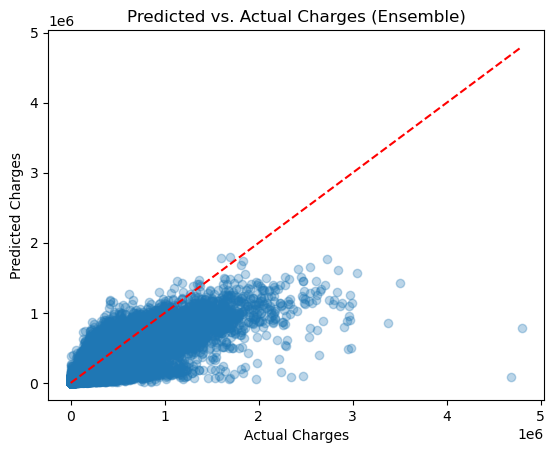

In [23]:
import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([0, y_true.max()], [0, y_true.max()], 'r--')  # perfect line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs. Actual Charges (Ensemble)")
plt.show()